In [3]:
"""Knowledge Graph RAG: Structure documents as a graph and traverse for retrieval."""

import os
import networkx as nx
from langchain_openai import ChatOpenAI

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]


def build_knowledge_graph() -> nx.DiGraph:
    """Build a simple knowledge graph from structured triples."""
    graph = nx.DiGraph()
    triples = [
        ("RAG", "uses", "Retrieval"),
        ("RAG", "uses", "Generation"),
        ("Retrieval", "method", "Vector Search"),
        ("Retrieval", "method", "Keyword Search"),
        ("Generation", "powered_by", "LLM"),
        ("LLM", "example", "GPT-4"),
        ("Vector Search", "uses", "Embeddings"),
    ]
    for subj, rel, obj in triples:
        graph.add_edge(subj, obj, relation=rel)
    return graph


def retrieve_subgraph(graph: nx.DiGraph, entity: str, depth: int = 2) -> str:
    """Retrieve facts by traversing neighbors up to a given depth."""
    if entity not in graph:
        return f"Entity '{entity}' not found in knowledge graph."

    facts = []
    visited = set()
    queue = [(entity, 0)]
    while queue:
        node, d = queue.pop(0)
        if node in visited or d > depth:
            continue
        visited.add(node)
        for _, neighbor, data in graph.edges(node, data=True):
            facts.append(f"{node} --[{data['relation']}]--> {neighbor}")
            queue.append((neighbor, d + 1))
    return "\n".join(facts)


def knowledge_graph_rag(query: str, entity: str) -> str:
    graph = build_knowledge_graph()
    context = retrieve_subgraph(graph, entity)

    llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY)
    response = llm.invoke(
        f"Answer using the knowledge graph facts below.\n"
        f"Facts:\n{context}\n\nQuestion: {query}"
    )
    return response.content


if __name__ == "__main__":
    print(knowledge_graph_rag("How does RAG use retrieval?", "RAG"))

RAG uses retrieval through two methods: Vector Search and Keyword Search. Vector Search utilizes embeddings to find relevant information, while Keyword Search relies on specific keywords to retrieve data.


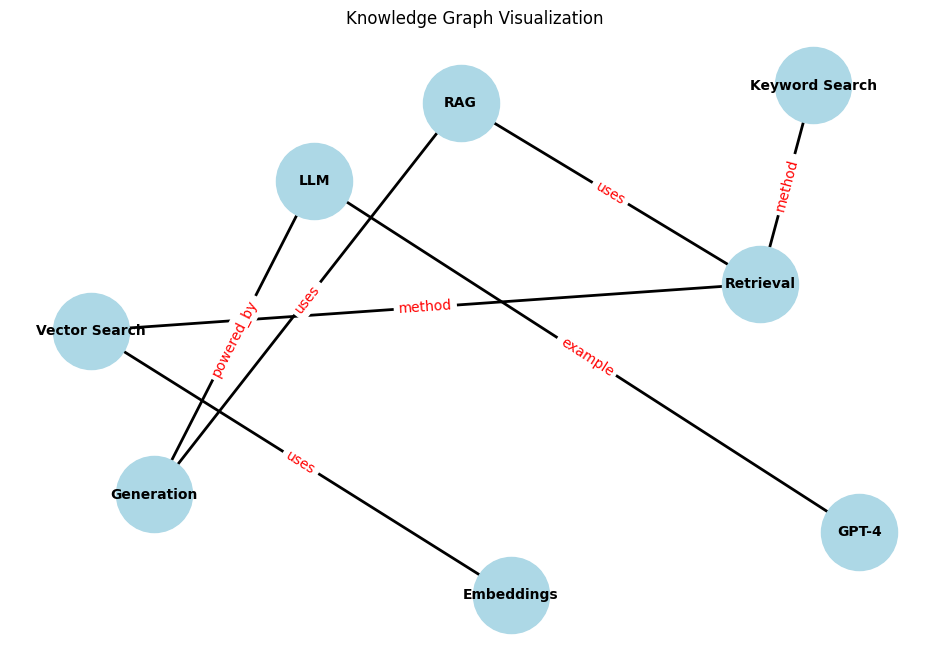

In [4]:
import matplotlib.pyplot as plt

# Build the graph
G = build_knowledge_graph()

# Create a plot
plt.figure(figsize=(12, 8))

# Use spring layout for positioning nodes
pos = nx.spring_layout(G, seed=42, k=2)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, arrowstyle='->', arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Draw edge labels (relations)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Knowledge Graph Visualization")
plt.axis('off')
plt.show()